This exercise aims to build on your knowledge of the big-four data science libraries to use Kestrel atmospheric measurement devices to estimate the height difference between the ground floor and sixth floor of the Geology building.

# Background

Air pressure monotonically decreases with height in the atmosphere.  This is simply due to the fact that *air pressure is a measure of the weight of everything above*.  So higher up in the atmosphere there is less atmosphere (weight) above, and pressure decreases.

One of the basic principles of fluid dynamics is that a *pressure gradient*--a change in pressure over some distance--exerts a net force on the fluid that, in the absence of other forces, would cause the fluid to move.  So why then does the atmosphere not flow away to space in response to this pressure gradient?

To a very good approximation, the atmosphere is in *hydrostatic balance*, meaning that the vertical pressure gradient is balanced by the force of gravity on the air; gravity effectively negates the pressure gradient force.  This leads to one of the most essential equations in atmospheric science:

$$ \frac{\partial p}{\partial z} = -\rho g$$

where $p$ is the atmospheric pressure, $z$ is height away from the surface, $\rho$ is air density, and $g$ is the gravitational acceleration (we'll use $g \approx 9.806~\text{m s}^{-2}$ here).

If we combine this with the ideal gas law (written in a form that is convenient for atmospheric gasses, where $R_d \approx 287~\text{J kg}^{-1}\text{K}^{-1}$ represents a constant for air with the composition of Earth's atmosphere), we get a differential equation for pressure.

$$\text{Ideal gas law: }~p = \rho R_d T \to $$

$$ \frac{\partial p}{\partial z} = - \frac{p g}{R_d T} $$

We can approximate the derivatives in this equation using finite differences: $\partial p/\partial z \to \Delta p / \Delta z$, where $\Delta$ represents a (presumably small) difference between two pressure or height measurements.  We can then use this to solve for the change in height as a function of changes in pressure:

$$ \Delta z \approx - \frac{R_d T}{g} \frac{\Delta p}{p}$$

# Estimating height

Now imagine that we have a device that records pressure and temperature every second or so.  If you take that device and walk up a set of stairs, the recorded pressure will drop a bit for every second that you're ascending.  A pair of measurements taken at consecutive times can be used to estimate $\Delta p$, and the average of the two measurements can be used to estimate $p$ and $T$ over tha same time frame.  These values can be plugged in to the above formula to estimate the change in height between the two measurements.  The sum of all the changes in height then gives an estimate of the total change in height; we will have numerically integrated the differential equation that comes from combining hydrostatic balance and the ideal gas law.

## Instructions

1. form groups of two or three
1. acquaint yourself with the Kestrel measuring devices, and pair it to at least one of your phones using [Kestrel Link](https://kestrelinstruments.com/link-connectivity)
1. ensure that you can record measurements and export them to csv
1. take the kestrel device down to the ground floor of the Geology building; go to the loop
1. start recording
1. either walk up the stairwell, or take the elevator, up to the 7th floor (you can only access this floor from the western stairwell)
1. end recording
1. export the data to a CSV file and add it to your course git folder (into a folder for lesson 04)
1. estimate the difference in height between the two floors using the method above (*hint*: you should use `pandas`, and you should be able to make a new column for the calculation of $\Delta p$ and $\Delta z$ for each measurement, and then use the `.sum()` method)

# The analysis

The following demonstrates my solution to the problem, using data that I collected on 9/14/23 using the process above, stored in the file `WEATHER_-_2406601_Sep_14_2023_5_36_58_PM.csv`.


In [1]:
""" Import libraries """
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Manual inspection of the data file shows that rows 0,1,2, and 4 aren't needed; row 3 has the header, and the rest of the rows contain the data.  The data are comma-delimited.

Further inspection shows that the header doesn't seem to match the columns.  For example, the last data column has an entry 'enter notes', which doesn't seem to be reflected in the header.  A manual count shows 16 columns listed in the header, so I'll direct pandas to only use the first 16 columns, which seems to work as shown below.

In [2]:
""" Load the data file. """

data_file = "WEATHER_-_2406601_Sep_14_2023_5_36_58_PM.csv"

# Read the data file into a pandas dataframe, skipping rows 0,1,2, and 4 and using row 3 as the header, and using only the first 16 columns.  Also have pandas parse the first column as a date.
kestrel_pd = pd.read_csv(
    data_file,
    skiprows=[0,1,2,4],
    header=0,
    usecols=range(0,16),
    delimiter=',',
    parse_dates=[0],
)

# show just the first few rows of the table 
kestrel_pd.head()


,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill
0,2023-09-14 17:34:58,70.0,56.8,44.7,991.5,179,991.6,0.0,68.2,47.5,485,--,--,--,--,69.8
1,2023-09-14 17:35:03,70.2,57.2,45.7,991.0,183,991.1,0.0,68.9,48.3,496,--,--,--,--,70.2
2,2023-09-14 17:35:08,70.2,57.4,46.2,991.2,183,991.2,0.0,68.9,48.5,494,--,--,--,--,70.2
3,2023-09-14 17:35:13,69.9,57.2,46.6,991.2,183,991.2,0.0,68.4,48.6,490,--,--,--,--,69.8
4,2023-09-14 17:35:18,69.8,57.2,46.9,991.0,184,991.1,0.0,68.2,48.6,488,--,--,--,--,69.6


Text(0.5, 0, 'Time')

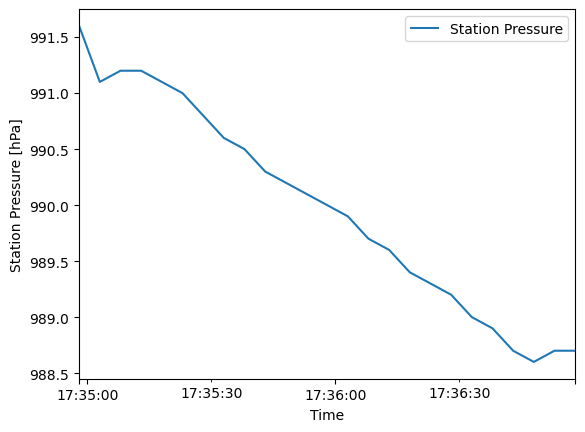

In [3]:
""" Plot a timeseries of the station pressure."""

kestrel_pd.plot(x = "FORMATTED DATE_TIME", y = "Station Pressure");
plt.ylabel("Station Pressure [hPa]")
plt.xlabel("Time")

Pressure decreases with time, as expected, given that I went up a few floors.  I intentionally stood still at the top for about 30 seconds to give the device time to vary a bit, which shows up clearly in the graph.

In [4]:
""" Calculate the pressure changes between the measurements. """ 

# Calculate the pressure change between measurements
kestrel_pd["delta_P_Pa"] = kestrel_pd["Station Pressure"].diff()*100 # convert to Pa also
# set the first value to zero
kestrel_pd.loc[0,"delta_P_Pa"] = 0
kestrel_pd

# calculate the average pressure between each two measurements, converting to Pa
kestrel_pd["avg_P_Pa"] = 100*(kestrel_pd["Station Pressure"] + kestrel_pd["Station Pressure"].shift(1))/2
# set the first value to the first measurement
kestrel_pd.loc[0,"avg_P_Pa"] = kestrel_pd.loc[1,"Station Pressure"]*100
kestrel_pd

# calculate the average temperature between each two measurements, converting to K from F
kestrel_pd["avg_T_K"] = (5/9)*(kestrel_pd["Temperature"] + kestrel_pd["Temperature"].shift(1))/2 - 32 + 273.15
# set the first value to the first measurement
kestrel_pd.loc[0,"avg_T_K"] = kestrel_pd.loc[1,"Temperature"] + 273.15

kestrel_pd



,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill,delta_P_Pa,avg_P_Pa,avg_T_K
0,2023-09-14 17:34:58,70.0,56.8,44.7,991.5,179,991.6,0.0,68.2,47.5,485,--,--,--,--,69.8,0.0,99110.0,343.350000
1,2023-09-14 17:35:03,70.2,57.2,45.7,991.0,183,991.1,0.0,68.9,48.3,496,--,--,--,--,70.2,-50.0,99135.0,280.094444
2,2023-09-14 17:35:08,70.2,57.4,46.2,991.2,183,991.2,0.0,68.9,48.5,494,--,--,--,--,70.2,10.0,99115.0,280.150000
3,2023-09-14 17:35:13,69.9,57.2,46.6,991.2,183,991.2,0.0,68.4,48.6,490,--,--,--,--,69.8,0.0,99120.0,280.066667
4,2023-09-14 17:35:18,69.8,57.2,46.9,991.0,184,991.1,0.0,68.2,48.6,488,--,--,--,--,69.6,-10.0,99115.0,279.955556
5,2023-09-14 17:35:23,69.5,57.2,47.1,991.0,185,991.0,0.0,67.8,48.5,484,--,--,--,--,69.4,-10.0,99105.0,279.844444
6,2023-09-14 17:35:28,69.5,57.2,47.6,990.7,187,990.8,0.0,68.0,48.7,486,--,--,--,--,69.4,-20.0,99090.0,279.761111
7,2023-09-14 17:35:33,69.3,57.4,48.0,990.5,188,990.6,0.0,67.8,48.8,485,--,--,--,--,69.3,-20.0,99070.0,279.705556
8,2023-09-14 17:35:38,69.2,57.2,48.0,990.5,189,990.5,0.0,67.5,48.7,484,--,--,--,--,69.1,-10.0,99055.0,279.622222
9,2023-09-14 17:35:43,69.1,57.0,47.9,990.2,190,990.3,0.0,67.5,48.6,483,--,--,--,--,69.1,-20.0,99040.0,279.566667


In [5]:
""" Calculate the change in height between each measurement. """

# set constants
Rd = 287 # J/kg/K
g = 9.806 # m/s^2

# calculate the change in height between each measurement
kestrel_pd["delta_h_m"] = - Rd*kestrel_pd["avg_T_K"]*kestrel_pd["delta_P_Pa"]/(g*kestrel_pd["avg_P_Pa"])

kestrel_pd

,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill,delta_P_Pa,avg_P_Pa,avg_T_K,delta_h_m
0,2023-09-14 17:34:58,70.0,56.8,44.7,991.5,179,991.6,0.0,68.2,47.5,485,--,--,--,--,69.8,0.0,99110.0,343.350000,-0.000000
1,2023-09-14 17:35:03,70.2,57.2,45.7,991.0,183,991.1,0.0,68.9,48.3,496,--,--,--,--,70.2,-50.0,99135.0,280.094444,4.134638
2,2023-09-14 17:35:08,70.2,57.4,46.2,991.2,183,991.2,0.0,68.9,48.5,494,--,--,--,--,70.2,10.0,99115.0,280.150000,-0.827259
3,2023-09-14 17:35:13,69.9,57.2,46.6,991.2,183,991.2,0.0,68.4,48.6,490,--,--,--,--,69.8,0.0,99120.0,280.066667,-0.000000
4,2023-09-14 17:35:18,69.8,57.2,46.9,991.0,184,991.1,0.0,68.2,48.6,488,--,--,--,--,69.6,-10.0,99115.0,279.955556,0.826684
5,2023-09-14 17:35:23,69.5,57.2,47.1,991.0,185,991.0,0.0,67.8,48.5,484,--,--,--,--,69.4,-10.0,99105.0,279.844444,0.826440
6,2023-09-14 17:35:28,69.5,57.2,47.6,990.7,187,990.8,0.0,68.0,48.7,486,--,--,--,--,69.4,-20.0,99090.0,279.761111,1.652637
7,2023-09-14 17:35:33,69.3,57.4,48.0,990.5,188,990.6,0.0,67.8,48.8,485,--,--,--,--,69.3,-20.0,99070.0,279.705556,1.652643
8,2023-09-14 17:35:38,69.2,57.2,48.0,990.5,189,990.5,0.0,67.5,48.7,484,--,--,--,--,69.1,-10.0,99055.0,279.622222,0.826200
9,2023-09-14 17:35:43,69.1,57.0,47.9,990.2,190,990.3,0.0,67.5,48.6,483,--,--,--,--,69.1,-20.0,99040.0,279.566667,1.652322


In [6]:
""" Sum the changes in height to estimate the total change in height. """

# calculate the total change in height
kestrel_pd["h_m"] = kestrel_pd["delta_h_m"].cumsum()


# print the total change in height
total_height_m = kestrel_pd['h_m'].iloc[-1]
total_height_ft = total_height_m*3.28084 # convert to feet
print(f"The total change in height is {total_height_ft:2.2f} ft")

# print the esimated height of each floor
num_floors = 7
floor_height_ft = round(total_height_ft/num_floors)
print(f"The estimated height of each floor is {floor_height_ft} ft")

The total change in height is 78.67 ft
The estimated height of each floor is 11 ft
